# Tutorial 4: Hyperfine Structure of Sodium D<sub>2</sub> Line

For atoms with hyperfine structure the nuclear spin `I` is no longer zero so there is coupling between the nuclear magnetic moment of the atom and the angular momentum of the electron cloud. This gives the atom hyperfine stucture. This can be modelled by using `LASED`. The advantage of this full quantum electrodynamical treatment of the atom is that the equations of motion for an atom with hyperfine structure are more accurately described than using a semiclassical approach.

In [17]:
import LASED as las
import numpy as np
import plotly.graph_objects as go
import time

## Hyperfine Structure Coupling

Hyperfine splitting of atomic energy levels is from the coupling of the nuclear-spin (iso-spin) I with the sum of the state's spin S and orbiatl angular momentum L. This results in a total angular momentum F:

$$
F = I + J = I + L + S
$$

If an atom has non-zero nuclear spin then the projection of the electron's angular momentum is $m_F$. This results in a different coupling between states (different dipole operator matrix element which couple two states together). The coupling between ground state |g> with angular momentum |F', m$_F$> and excited state |e> with angular momentum |F, m$_F$> is [[Farrell 1995]](https://doi.org/10.1088/0305-4470/28/1/023):

$$
C^q_{eg} = (-1)^{1/2(1+q)F+F'+J+J'+I+L+S-m_F+1}\sqrt{(2F+1)(2F'+1)(2J+1)(2J'+1)(2L+1)} \\
\begin{pmatrix} F & 1 & F' \\ -m_F & q &m_F'\end{pmatrix}\begin{Bmatrix}J & F & I \\ F' & J' & 1\end{Bmatrix}\begin{Bmatrix}L & J & S \\ J' & L' & 1\end{Bmatrix}
$$

where q is the polarisation of the laser radiation: -1 if $\sigma+$, +1 if $\sigma-$, and 0 if $\pi$.

These couplings are automatically calculated when using `LASED` with the input parameters given to the `LaserAtomSystem`.


## Sodium D$_2$ Line

In 1988 Farrell published a paper modelling the orange Sodium D$_2$ line, specifically the 3$^2$S$_{1/2}$ (F' = 2) to the 3$^2$P$_{3/2}$ (F = 3,2,1) transition. See [Farrell's paper ](https://doi.org/10.1103/PhysRevA.37.4240) here. Farrell also compares the QED approach to the semi-classical (SC) model and shows that the SC model agrees with the QED model at low intensities but the approaches diverge at higher intensities. In this tutorial we will reproduce Farrell's results.

The data for the Sodium D line can be found [here](https://steck.us/alkalidata/sodiumnumbers.1.6.pdf). A level diagram of the sructure of this Sodium transition is displayed below.

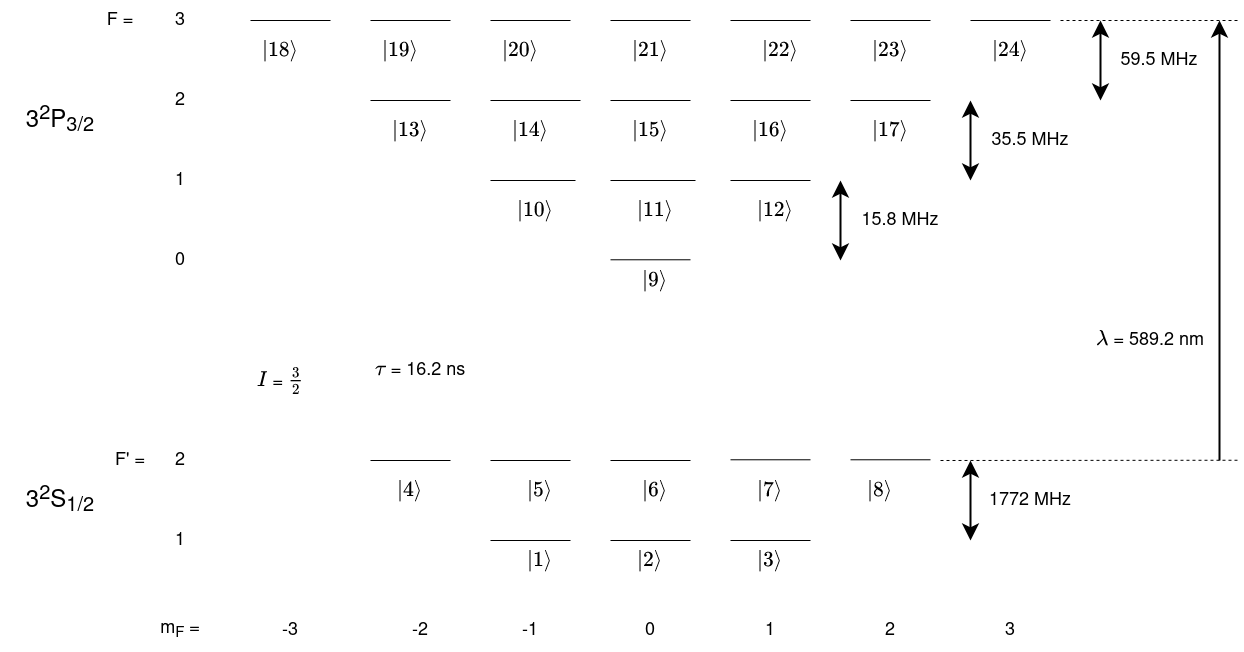

In [18]:
from IPython.display import Image
Image("LevelDiagrams/Na-3S1_2to3P3_2.png")

As you can see by the diagram above, each ground and excited state has multiple sub-states at different energies. The differing ernergies of the sub-states can be declared by using the keyword `w` and entering the angular frequency in Grad/s corresponding to the energy when creating `State` objects. These energies are relative so a zero point must be defined. In this example the zero energy is the energy of the F' = 2 ground state.

Since there are many states and it is cumbersome to write out all states explicitly `LASED` has a function to generate all the sub-states for a given set of quantum numbers and angular frequency. This function is the `generateSubStates(label_from, w, L, S, I, F)` function. The `label_from` keyword defines the`label` attached to each sub-state generated. The function will generate the sub-state with the least `m` value (projection of total angular momentum) first with the integer given with the keyword `label_from` and generate the rest of the states in ascending order of `m`, giving each `State` an increasing label number.

In [2]:
# 3^2S_{1/2} -> 3^2P_{3/2}
wavelength_na = 589.159e-9  # Wavelength in m
w_e = las.angularFreq(wavelength_na)
tau_na = 16.24  # in ns

I_Na = 3/2  # Isospin for sodium 
PI = np.pi

# Energy Splittings
w1 = 1.77*2*PI # Splitting of 3^2S_{1/2}(F = 1) - (F = 2) in Grad/s
w2 = 0.0158*2*PI  # Splitting between 3^2P_{3/2} (F = 0) and F = 1 in Grad/s
w3 = 0.0355*2*PI  # Splitting between 3^2P_{3/2} (F = 1) and F = 2 in Grad/s
w4 = 0.0595*2*PI  # Splitting between 3^2P_{3/2} (F = 2) and F = 3 in Grad/s

# Detunings
w_Fp1 = -1*w1
w_F0 = w_e-(w4+w3+w2)
w_F1 = w_e-(w4+w3)
w_F2 = w_e-w4
w_F3 = w_e

# Model 
# 3^2S_{1/2} F' = 1
Fp1 = las.generateSubStates(label_from = 1, w = w_Fp1, L = 0, S = 1/2, I = I_Na, F = 1)
# 3^2S_{1/2} F' = 2
Fp2 = las.generateSubStates(label_from = 4, w = 0, L = 0, S = 1/2, I = I_Na, F = 2)
# 3^2P_{3/2} F = 0
F0 = las.generateSubStates(label_from = 9, w = w_F0, L = 1, S = 1/2, I = I_Na, F = 0)
# 3^2P_{3/2} F = 1
F1 = las.generateSubStates(label_from = 10, w = w_F1, L = 1, S = 1/2, I = I_Na, F = 1)
# 3^2P_{3/2} F = 2 
F2 = las.generateSubStates(label_from = 13, w = w_F2, L = 1, S = 1/2, I = I_Na, F = 2)
# 3^2P_{3/2} F = 3
F3 = las.generateSubStates(label_from = 18, w = w_F3, L = 1, S = 1/2, I = I_Na, F = 3)

G_na = Fp1 + Fp2
E_na = F0 + F1 + F2 + F3

# Laser parameters
intensity_na = 85.6 # mW/mm^-2
Q_na = [0]

# Simulation parameters
start_time = 0
stop_time = 500 # in ns
time_steps = 501
time_na = np.linspace(start_time, stop_time, time_steps)

Now, we can declare the `LaserAtomSystem`. The timing code does not have to be input and shows how much time a 24-level system takes to solve. 

In [3]:
sodium_system = las.LaserAtomSystem(E_na, G_na, tau_na, Q_na, wavelength_na, 
                                 laser_intensity = intensity_na)
tic = time.perf_counter()
sodium_system.timeEvolution(time_na)
toc = time.perf_counter()
print(f"The code finished in {toc-tic:0.4f} seconds")

Populating ground states equally as the initial condition.
The code finished in 642.0120 seconds


## Saving and Plotting

Save the data as a csv file and plot the data.

In [4]:
sodium_system.saveToCSV("SavedData/SodiumD2Line86mW.csv")

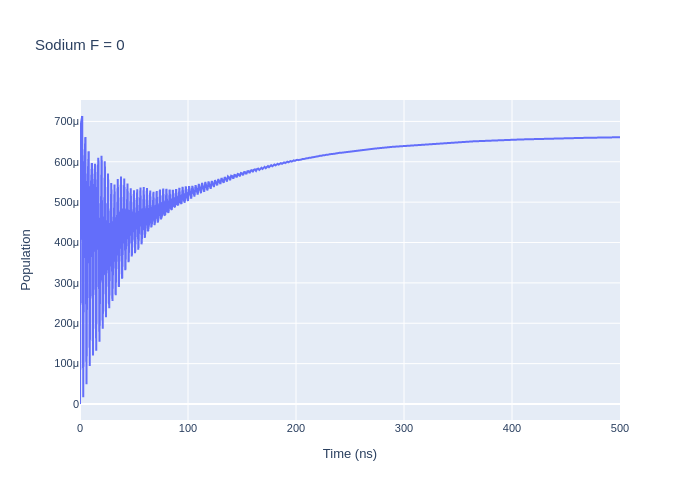

In [8]:
las_sys = sodium_system

rho_to_plot = [ [abs(rho) for rho in las_sys.Rho_t(s, s)] for s in F0]

fig_na = go.Figure()

for i, rho_ee in enumerate(rho_to_plot):
    fig_na.add_trace(go.Scatter(x = time_na, 
                                y = rho_ee,
                                name = f"m_F = {F0[i].m}",
                               mode = 'lines'))

fig_na.update_layout(title = "Sodium F = 0",
                 xaxis_title = "Time (ns)",
                 yaxis_title = "Population",
                font = dict(
                    size = 11))
fig_na.write_image("SavedPlots/NaF=0I=856.png")
Image("SavedPlots/NaF=0I=856.png")

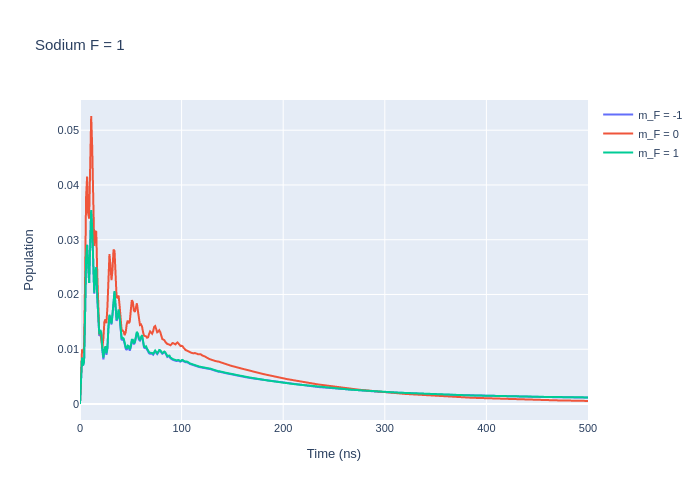

In [9]:
las_sys = sodium_system

rho_to_plot = [ [abs(rho) for rho in las_sys.Rho_t(s, s)] for s in F1]

fig_na = go.Figure()

for i, rho_ee in enumerate(rho_to_plot):
    fig_na.add_trace(go.Scatter(x = time_na, 
                                y = rho_ee,
                                name = f"m_F = {F1[i].m}",
                               mode = 'lines'))

fig_na.update_layout(title = "Sodium F = 1",
                 xaxis_title = "Time (ns)",
                 yaxis_title = "Population",
                font = dict(
                    size = 11))
fig_na.write_image("SavedPlots/NaF=1I=856.png")
Image("SavedPlots/NaF=1I=856.png")

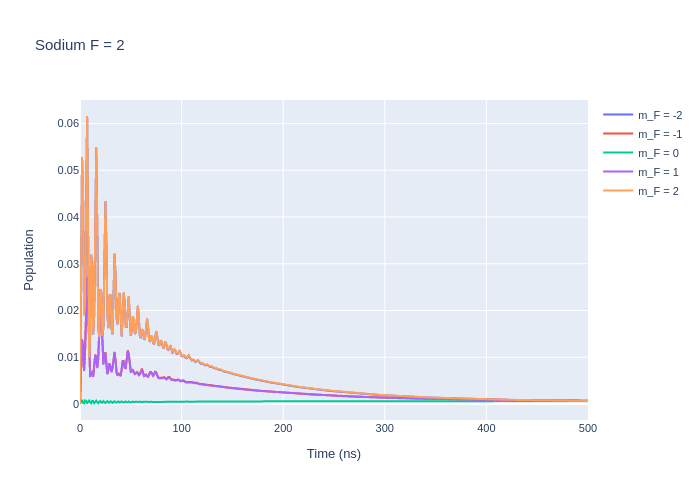

In [10]:
las_sys = sodium_system

rho_to_plot = [ [abs(rho) for rho in las_sys.Rho_t(s, s)] for s in F2]

fig_na = go.Figure()

for i, rho_ee in enumerate(rho_to_plot):
    fig_na.add_trace(go.Scatter(x = time_na, 
                                y = rho_ee,
                                name = f"m_F = {F2[i].m}",
                               mode = 'lines'))

fig_na.update_layout(title = "Sodium F = 2",
                 xaxis_title = "Time (ns)",
                 yaxis_title = "Population",
                font = dict(
                    size = 11))
fig_na.write_image("SavedPlots/NaF=2I=856.png")
Image("SavedPlots/NaF=2I=856.png")

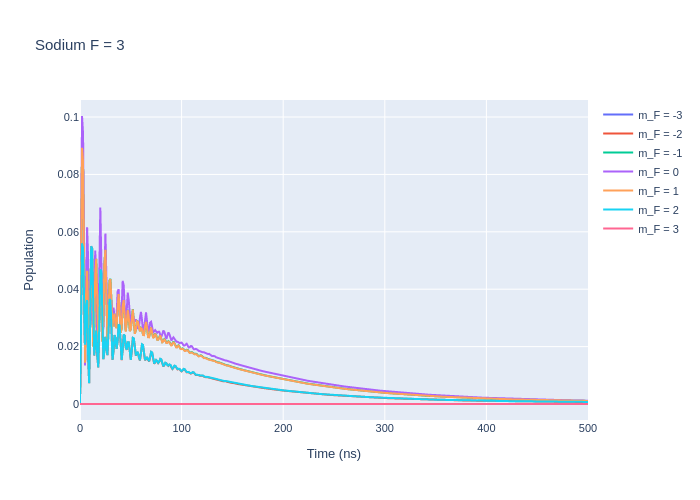

In [11]:
las_sys = sodium_system

rho_to_plot = [ [abs(rho) for rho in las_sys.Rho_t(s, s)] for s in F3]

fig_na = go.Figure()

for i, rho_ee in enumerate(rho_to_plot):
    fig_na.add_trace(go.Scatter(x = time_na, 
                                y = rho_ee,
                                name = f"m_F = {F3[i].m}",
                               mode = 'lines'))

fig_na.update_layout(title = "Sodium F = 3",
                 xaxis_title = "Time (ns)",
                 yaxis_title = "Population",
                font = dict(
                    size = 11))
fig_na.write_image("SavedPlots/NaF=3I=856.png")
Image("SavedPlots/NaF=3I=856.png")

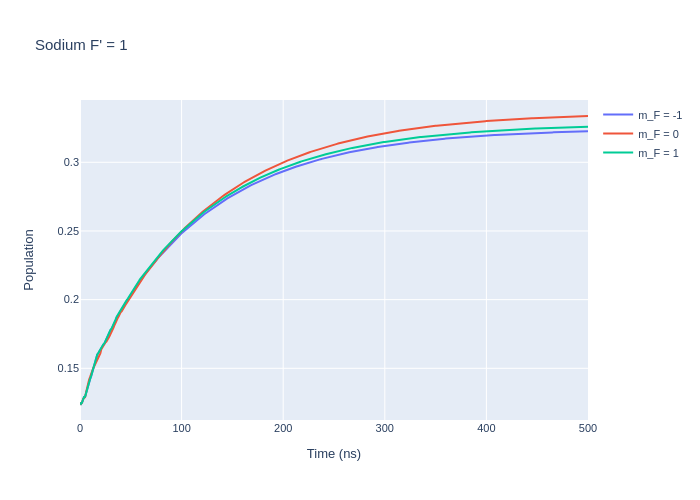

In [14]:
fig_na_lower = go.Figure()

rho_to_plot = [ [abs(rho) for rho in las_sys.Rho_t(s, s)] for s in Fp1]

for i, rho_gg in enumerate(rho_to_plot):
    fig_na_lower.add_trace(go.Scatter(x = time_na, 
                                y = rho_gg,
                                name = f"m_F = {Fp1[i].m}",
                               mode = 'lines'))
fig_na_lower.update_layout(title = "Sodium F' = 1",
                 xaxis_title = "Time (ns)",
                 yaxis_title = "Population",
                font = dict(
                    size = 11))
fig_na_lower.write_image("SavedPlots/NaFp=1I=856.png")
Image("SavedPlots/NaFp=1I=856.png")

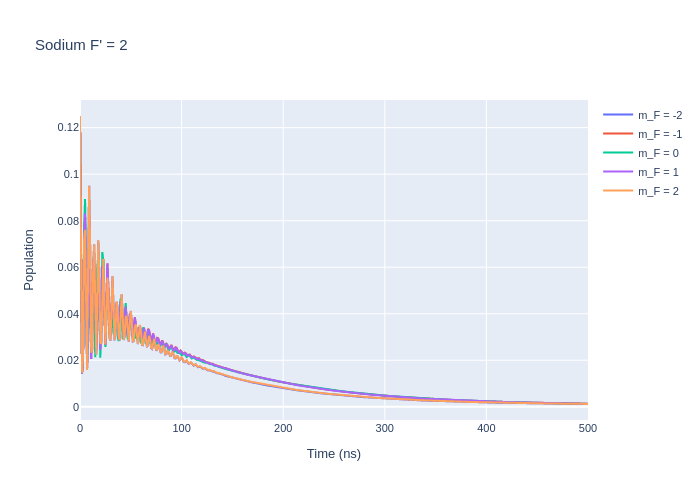

In [16]:
fig_na_lower = go.Figure()

rho_to_plot = [ [abs(rho) for rho in las_sys.Rho_t(s, s)] for s in Fp2]

for i, rho_gg in enumerate(rho_to_plot):
    fig_na_lower.add_trace(go.Scatter(x = time_na, 
                                y = rho_gg,
                                name = f"m_F = {Fp2[i].m}",
                               mode = 'lines'))
fig_na_lower.update_layout(title = "Sodium F' = 2",
                 xaxis_title = "Time (ns)",
                 yaxis_title = "Population",
                font = dict(
                    size = 11))
fig_na_lower.write_image("SavedPlots/NaFp=2I=856.png")
Image("SavedPlots/NaFp=2I=856.png")